# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Блок с импортом библиотек.
!pip install phik -q
!pip install -U scikit-learn -q
!pip install lightgbm -q
!pip install catboost -q

import phik
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import cv
from lightgbm import LGBMRegressor

In [2]:
# Зададим константы.
RANDOM_STATE = 4221
TEST_SIZE = 0.25

### Обзор исходных данных

In [3]:
# Функция для обзора исходных данных.
def df_informer(df):
    print('Первые 20 строк таблицы: \n')
    display(df.head(20))
    print('Общая информация о данных: \n')
    display(df.info())
    print('Количество явных дубликатов: ', df.duplicated().sum())
    print('Сводная статистика по данным: \n')
    display(df.describe().T)
    display(df.describe(include='object').T)
    display(df.describe(include='datetime').T)

In [4]:
# Изучим исходные данные.
autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
df_informer(autos)

Первые 20 строк таблицы: 



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPicture

None

Количество явных дубликатов:  4
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


,count,unique,top,freq
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
Repaired,283215,2,no,247161


/tmp/ipykernel_176/838639142.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='datetime').T)
/tmp/ipykernel_176/838639142.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='datetime').T)
/tmp/ipykernel_176/838639142.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='datetime').T)


,count,unique,top,freq,first,last
DateCrawled,354369,271174,2016-03-24 14:49:47,7,2016-03-05 14:06:22,2016-04-07 14:36:58
DateCreated,354369,109,2016-04-03 00:00:00,13719,2014-03-10 00:00:00,2016-04-07 00:00:00
LastSeen,354369,179150,2016-04-06 13:45:54,17,2016-03-05 14:15:08,2016-04-07 14:58:51


Отметим следующее:

- В данных 354369 записей и 16 признаков. Есть пропуски. В целом данных останется более чем достаточно, даже если просто сбросить все пропуски. 
- Имеются 4 явных дубликата.
- Признак **NumberOfPictures** среди значений имеет только нули.
- Есть нулевое значение в целевом признаке. Кто-то решил подарить свой автомобиль или не указал цену при регистрации анкеты? Модель такую связь точно не обнаружит, бесплатные автомобили лучше убрать из выборки.
- Есть нулевое значение и в значениях мощности двигателя. Теоретически кто-то мог выставить на продажу автомобиль не на ходу. Хотя вероятнее, что значение просто забыли указать, а 0 выствляется стандартно при оформлении анкеты. Другое дело значение в 20000 л. с. Поисковик Яндекса утверждает, что максимальную мощность двигателя сегодняя имеет спорткар Koenigsegg Gemera с отметкой в 2300 л. с., если только «Не бит, не крашен» не планируют перепродавать ракеты, мы, пожалуй, ограничим выборку данным значением.
- **RegistrationYear** в качестве самого раннего года регистрации автомобиля имеет 1000-ый год. Была ли это мангонель или машина времени возможно скоро выясним. Максимальное значение — 9999. Даже Эмметт Браун не заходил так далеко...
- С месяцем регистрации тоже что-то непонятное, имеется нулевое значение.
- Признак **Repaired** имеет больше 70 тыс. пропусков, что не очень хорошо. Признак определённо важный, информация о прошлых технических неисправностях автомобиля не может не отразиться на его рыночной стоимости. При этом ситуация, когда создатели анкет предпочитали умалчивать о состоянии автомобиля довольно распространена, возможно есть смысл сохранить эту информацию. Добаим дополнительную категорию и сравним корреляцию признака с целевым.

### Предобработка данных

**Обработка неявных дубликатов:**

Проверим категориальные признаки на наличие неявных дубликатов.

In [5]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [6]:
autos['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [7]:
autos['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [8]:
autos['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Исправим дубликаты.

In [9]:
def fuel_replacer(fuel):
    if fuel == 'gasoline':
        return 'petrol'
    else:
        return fuel
    
autos['FuelType'] = autos['FuelType'].apply(fuel_replacer)

autos['FuelType'].value_counts()

petrol      315072
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

**RegistrationMonth:**

Взглянем подробнее на месяц регистрации автомобиля. Может, найдётся какая-то логическая связь существования нулевого значения.

In [10]:
autos.groupby('RegistrationMonth')['RegistrationMonth'].count()

RegistrationMonth
0     37352
1     23219
2     21267
3     34373
4     29270
5     29153
6     31508
7     27213
8     22627
9     23813
10    26099
11    24186
12    24289
Name: RegistrationMonth, dtype: int64

Итак, имеем 13 значений месяца, причём нулевой самый распространённый. Вероятно, так был обозначен пропуск, если месяц регистрации не был известен. Впрочем, вероятно месяц регистрации никак не влияет на рыночную стоимость автомобиля и данный признак просто отпадёт.

**RegistrationYear, Power, Price:**

Мангонели с делорианами искать не будем, оставим записи с регистрацией автомобиля с 1900-го по 2016-ый год.

In [11]:
autos = autos[(autos['RegistrationYear'] >= 1970) & (autos['RegistrationYear'] <= 2016)]
autos = autos[(autos['Power'] <= 2300)]
autos = autos[autos['Price'] != 0]
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328554 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328554 non-null  datetime64[ns]
 1   Price              328554 non-null  int64         
 2   VehicleType        308745 non-null  object        
 3   RegistrationYear   328554 non-null  int64         
 4   Gearbox            313208 non-null  object        
 5   Power              328554 non-null  int64         
 6   Model              313293 non-null  object        
 7   Kilometer          328554 non-null  int64         
 8   RegistrationMonth  328554 non-null  int64         
 9   FuelType           304625 non-null  object        
 10  Brand              328554 non-null  object        
 11  Repaired           269072 non-null  object        
 12  DateCreated        328554 non-null  datetime64[ns]
 13  NumberOfPictures   328554 non-null  int64   

**Power и нулевые значения:**

С нулевым значением мощности двигателя тоже желательно что-то сделать. Значения по сути являются пропусками. Почему их просто не срезать так же, как мы это сделали с аномально большими значениями? Потому что так мы выбросим из датасета следующее количество данных:

In [12]:
autos[autos['Power'] == 0]['Power'].count()

32465

Около 10% оставшегося датасета. 

У нас есть значения брэнда и модели автомобиля, можем сгруппировать по ним данные и вычислить среднее или медианное значение, которым заменим нули.

In [13]:
# Заменим нули на значения пропусков.
autos['Power'].replace(0, pd.NA, inplace=True)
autos['Power'] = pd.to_numeric(autos['Power'], errors='coerce')

# Группируем данные по брэнду и модели и вычисляем медиану.
median = autos.groupby(['Brand', 'Model'])['Power'].median().reset_index()

autos = pd.merge(autos, median, on=['Brand', 'Model'], how='left', suffixes=('', '_median'))

autos['Power'] = autos.apply(lambda row: row['Power_median'] if pd.isna(row['Power']) else row['Power'], axis=1)

autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328554 entries, 0 to 328553
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328554 non-null  datetime64[ns]
 1   Price              328554 non-null  int64         
 2   VehicleType        308745 non-null  object        
 3   RegistrationYear   328554 non-null  int64         
 4   Gearbox            313208 non-null  object        
 5   Power              324310 non-null  float64       
 6   Model              313293 non-null  object        
 7   Kilometer          328554 non-null  int64         
 8   RegistrationMonth  328554 non-null  int64         
 9   FuelType           304625 non-null  object        
 10  Brand              328554 non-null  object        
 11  Repaired           269072 non-null  object        
 12  DateCreated        328554 non-null  datetime64[ns]
 13  NumberOfPictures   328554 non-null  int64   

Большую часть пропусков получилось заполнить. Оставшиеся сбросим.

In [14]:
autos = autos.dropna(subset=['Power'])
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324310 entries, 0 to 328553
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        324310 non-null  datetime64[ns]
 1   Price              324310 non-null  int64         
 2   VehicleType        306555 non-null  object        
 3   RegistrationYear   324310 non-null  int64         
 4   Gearbox            310889 non-null  object        
 5   Power              324310 non-null  float64       
 6   Model              313292 non-null  object        
 7   Kilometer          324310 non-null  int64         
 8   RegistrationMonth  324310 non-null  int64         
 9   FuelType           302549 non-null  object        
 10  Brand              324310 non-null  object        
 11  Repaired           267650 non-null  object        
 12  DateCreated        324310 non-null  datetime64[ns]
 13  NumberOfPictures   324310 non-null  int64   

In [15]:
autos['VehicleType'] = autos['VehicleType'].fillna('not specified')
autos['Model'] = autos['Model'].fillna('not specified')

**Repaired:**

В данном признаке мы столкнулись с наибольшим числом пропусков (около 20% всей выборки). Попробуем добавить признак с дополнительной категорией и сравним признаки на корреляции.

In [16]:
autos['repaired_advanced'] = autos['Repaired'].fillna('not specified')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324310 entries, 0 to 328553
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        324310 non-null  datetime64[ns]
 1   Price              324310 non-null  int64         
 2   VehicleType        324310 non-null  object        
 3   RegistrationYear   324310 non-null  int64         
 4   Gearbox            310889 non-null  object        
 5   Power              324310 non-null  float64       
 6   Model              324310 non-null  object        
 7   Kilometer          324310 non-null  int64         
 8   RegistrationMonth  324310 non-null  int64         
 9   FuelType           302549 non-null  object        
 10  Brand              324310 non-null  object        
 11  Repaired           267650 non-null  object        
 12  DateCreated        324310 non-null  datetime64[ns]
 13  NumberOfPictures   324310 non-null  int64   

In [17]:
# Cбросим неинформативные признаки и явные дубликаты.
autos = autos.drop(['NumberOfPictures', 'Power_median'], axis=1)
autos = autos.drop_duplicates()

Оставшиеся пропуски заполним наиболее частым значением.

In [18]:
# Пайплайн для замены пропущенных значений
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

nan_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
autos[nan_cols] = imputer_pipe.fit_transform(autos[nan_cols])

autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324306 entries, 0 to 328553
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        324306 non-null  datetime64[ns]
 1   Price              324306 non-null  int64         
 2   VehicleType        324306 non-null  object        
 3   RegistrationYear   324306 non-null  int64         
 4   Gearbox            324306 non-null  object        
 5   Power              324306 non-null  float64       
 6   Model              324306 non-null  object        
 7   Kilometer          324306 non-null  int64         
 8   RegistrationMonth  324306 non-null  int64         
 9   FuelType           324306 non-null  object        
 10  Brand              324306 non-null  object        
 11  Repaired           324306 non-null  object        
 12  DateCreated        324306 non-null  datetime64[ns]
 13  PostalCode         324306 non-null  int64   

In [19]:
# РЕВЬЮЕР
autos[['Brand', 'Model']].head()

,Brand,Model
0,volkswagen,golf
1,audi,not specified
2,jeep,grand
3,volkswagen,golf
4,skoda,fabia


**Итоги предобработки данных:**

- Удалены записи с годом регистрации автомобиля до 1900-го и после 2016-го.
- Выборка ограничена записями с мощностью двигателя автомобиля до 2300 л. с.
- Удалены записи с бесплатными автомобилями.
- Нулевые значения мощности двигателя заполнены медианой в зависимости от брэнда и модели автомобиля. Пропуски, которые не получилось заполнить, были удалены.
- Добавлен признак **repaired_advanced**. Он включил в себя значения признака **Rpaired** с заполнением пропусков значением **not specified**.
- Были сброшены явные дубликаты.
- Оставшиеся пропуски заполнены наиболее частым значением.

### Корреляционный анализ

In [20]:
# Функция для отображения матрицы корреляции.
def phik_matrix_creator(df):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1).phik_matrix(
    interval_cols=[
        'Price', 
        'RegistrationYear', 
        'Power',
        'Kilometer',
        'RegistrationMonth',
        'PostalCode'
    ]
), annot=True, cmap='coolwarm', fmt='.2f')

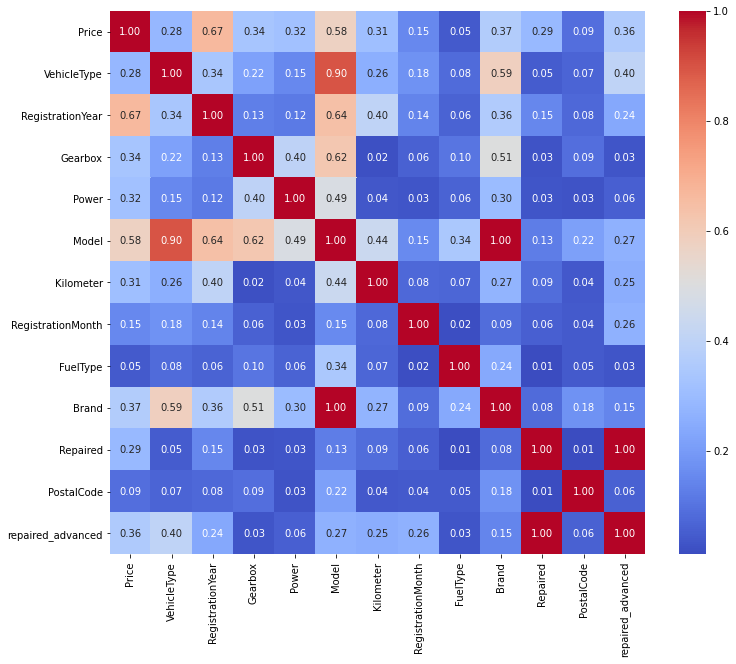

In [21]:
phik_matrix_creator(autos)

Анализ корреляции:

- Наблюдается заметная связь таргета с моделью автомобиля и годом регистрации: 0.58—0.67.
- Как и ожидалось, почтовый индекс почти не имеет связи с ценой автомобиля. У значений месяца регистрации есть слабая связь с таргетом, однако не будем забывать, что мы оставили в данных значения "нулевого" месяца. Не исключено, что признак коррелирует с целевым случайным образом без реальной связи в данных.
- C дополнительным значением 'not specified', введённым вместо пропусков, признак с информацией о наличии технических проблем у автомобиля в прошлом продемонстрировал немного более сильную связь с целевым, чем если заполнить пропуски наиболее частым значением. Для обучения модели сохраним расширенный признак.
- Для остальных признаков отметим умеренную тесноту связи с целевым.

### Разделение на выборки

Итак, сперва срежем признаки, которые по итогу корреляционного анализа считаем не важными. Также уберём признаки с датами, с задачей предсказания цены автомобиля они нам не помогут.

In [22]:
# Cбрасываем признаки.
autos = autos.drop(['RegistrationMonth', 'PostalCode', 'Repaired', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

# Проверим, появились ли явные дубликаты.
autos.duplicated().sum()

47632

In [23]:
# Сбросим явные дубликаты.
autos = autos.drop_duplicates()

Теперь разделим данные на тренировочную и тестовую выборки.

In [24]:
# Разделяем таргет и входные признаки.
X = autos.drop('Price', axis=1)
y = autos['Price']

# Разделяем данные на тренировочные и тестовые.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

# Проверим размерность полученных выборок.
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (207505, 9)
X_test: (69169, 9)
y_train: (207505,)
y_test: (69169,)


### Сбор пайплайна

In [25]:
# Зададим списки признаков для кодирования и масштабирования.
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'repaired_advanced']
ord_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'repaired_advanced']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

In [26]:
# Создаём пайплайн с кодированием признаков OneHotEncoder.
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [27]:
# Создаём пайплайн с кодированием признаков OrdinalEncoder.
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', 
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simple_Imputer',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [28]:
# Объединим шаги по подготовке данных.
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [29]:
# Объединим шаги по подготовке данных доя модели lgbm.
lgbm_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

## Обучение моделей

### Обучение модели линейной регрессии

In [30]:
# Cоздаём итоговый пайплайн.
linear_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
) 

In [31]:
params = {}

linear_model = RandomizedSearchCV(
    linear_pipe,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=5,
    cv=2,
    verbose=5,
    random_state=RANDOM_STATE,
)

linear_model.fit(X_train, y_train)

cv_rmse_linear = (-1) * linear_model.best_score_
print('Лучшая модель: \n', linear_model.best_estimator_)
print('RMSE на кросс-валидации:', cv_rmse_linear)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END ..............................., score=-2735.777 total time=   9.9s
[CV 2/2] END ..............................., score=-2754.123 total time=  10.2s
Лучшая модель: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                

In [32]:
# Обучаем модель.
#%%time

linear_model.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'repaired_advanced']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('models', LinearRegression())])

In [33]:
linear_train_time = linear_model.cv_results_['mean_fit_time'][linear_model.best_index_]
print('Среднее время обучения модели:', linear_train_time, 'cекунд')

Среднее время обучения модели: 9.220217227935791 cекунд


In [35]:
# Выведем время предсказания и метрику на тренировочных данных.
#%%time

predictions_linear = linear_model.best_estimator_.predict(X_train)
linear_pred_time = linear_model.cv_results_['mean_score_time'][linear_model.best_index_]
pred_rmse_linear = (mean_squared_error(y_train, predictions_linear)) ** 0.5

print('Среднее время предсказания модели:', linear_pred_time, 'cекунд')
print('RMSE на тренировочной выборке:', pred_rmse_linear)

Среднее время предсказания модели: 0.848421573638916 cекунд
RMSE на тренировочной выборке: 2734.8363934205727


**Итоги обучения модели линейной регрессии:**

- Среднее время обучения модели: 9.220217227935791 cекунд
- Среднее время предсказания модели: 0.848421573638916 cекунд
- RMSE на кросс-валидации: 2744.950070552154
- RMSE на тренировочной выборке: 2734.8363934205727

### Обучение модели LightGBM

In [36]:
# Cоздаём итоговый пайплайн.
lgbm_pipe = Pipeline([
    ('preprocessor', lgbm_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

In [37]:
# Зададим словарь с гиперпараметрами.
params = {
    'models': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
    'models__n_estimators': range(50, 100, 10),
    'models__max_depth': range(3, 10),
    'models__num_leaves': range(5, 50, 5)
}

# Подберём модель с лучшими гиперпараметрами.
lgb_model = RandomizedSearchCV(
    lgbm_pipe,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=5,
    verbose=5,
    random_state=RANDOM_STATE,
)

lgb_model.fit(X_train, y_train)

cv_rmse_lgbm = (-1) * lgb_model.best_score_
print('Лучшая модель: \n', lgb_model.best_estimator_)
print('RMSE на кросс-валидации:', cv_rmse_lgbm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=50, models__num_leaves=25;, score=-1829.520 total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=50, models__num_leaves=25;, score=-1861.796 total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=50, models__num_leaves=25;, score=-1845.393 total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=50, models__num_leaves=25;, score=-1868.740 total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=50, models__num_leaves=25;, score=-1857.790 total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=80, models__num_leaves=30;, score=-1742.052 total time=   3.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=80, models__num_leaves=30;, score=-1778.728 total time=   3.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=80, models__num_leaves=30;, score=-1767.729 total time=   3.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=80, models__num_leaves=30;, score=-1791.877 total time=   3.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=9, models__n_estimators=80, models__num_leaves=30;, score=-1775.733 total time=   3.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=4, models__n_estimators=60, models__num_leaves=40;, score=-1908.913 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=4, models__n_estimators=60, models__num_leaves=40;, score=-1935.067 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=4, models__n_estimators=60, models__num_leaves=40;, score=-1920.556 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=4, models__n_estimators=60, models__num_leaves=40;, score=-1961.269 total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=4, models__n_estimators=60, models__num_leaves=40;, score=-1935.121 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=80, models__num_leaves=5;, score=-2027.508 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=80, models__num_leaves=5;, score=-2046.536 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=80, models__num_leaves=5;, score=-2042.035 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=80, models__num_leaves=5;, score=-2073.140 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=80, models__num_leaves=5;, score=-2057.187 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=60, models__num_leaves=15;, score=-1860.665 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=60, models__num_leaves=15;, score=-1891.898 total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=60, models__num_leaves=15;, score=-1886.014 total time=   2.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=60, models__num_leaves=15;, score=-1902.840 total time=   2.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=60, models__num_leaves=15;, score=-1883.980 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=10;, score=-1927.735 total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=10;, score=-1951.899 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=10;, score=-1943.682 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=10;, score=-1971.182 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=10;, score=-1946.259 total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=8, models__n_estimators=70, models__num_leaves=15;, score=-1832.272 total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=8, models__n_estimators=70, models__num_leaves=15;, score=-1864.704 total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=8, models__n_estimators=70, models__num_leaves=15;, score=-1856.063 total time=   2.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=8, models__n_estimators=70, models__num_leaves=15;, score=-1878.338 total time=   2.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=8, models__n_estimators=70, models__num_leaves=15;, score=-1861.146 total time=   2.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=30;, score=-1736.559 total time=   4.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=30;, score=-1779.611 total time=   3.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=30;, score=-1764.651 total time=   3.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=30;, score=-1783.860 total time=   4.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=30;, score=-1774.504 total time=   4.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=35;, score=-1794.966 total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=35;, score=-1822.137 total time=   3.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=35;, score=-1809.964 total time=   3.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=35;, score=-1831.698 total time=   3.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=6, models__n_estimators=60, models__num_leaves=35;, score=-1818.053 total time=   3.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40;, score=-1721.039 total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40;, score=-1755.146 total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40;, score=-1739.182 total time=   4.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40;, score=-1763.336 total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/5] END models=LGBMRegressor(random_state=4221, verbose=-1), models__max_depth=7, models__n_estimators=90, models__num_leaves=40;, score=-1755.649 total time=   4.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Лучшая модель: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simple_Imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', '

In [38]:
# Обучаем модель.
#%%time

lgb_model.best_estimator_.fit(X_train, y_train)
lgb_train_time = lgb_model.cv_results_['mean_fit_time'][lgb_model.best_index_]
print('Среднее время обучения модели:', lgb_train_time, 'cекунд')

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Среднее время обучения модели: 3.8394303798675535 cекунд


In [39]:
# Получим предсказания и вычислим значение метрики на тестовой выборки.
#%%time

predictions_lgbm = lgb_model.best_estimator_.predict(X_train)
lgb_pred_time = lgb_model.cv_results_['mean_score_time'][lgb_model.best_index_]
pred_rmse_lgbm = (mean_squared_error(y_train, predictions_lgbm)) ** 0.5

print('Среднее время предсказания модели:', lgb_pred_time, 'cекунд')
print('RMSE на тренировочной выборке:', pred_rmse_lgbm)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Среднее время предсказания модели: 0.4230950832366943 cекунд
RMSE на тренировочной выборке: 1712.1060955608928


**Итоги обучения модели LightGBM:**

- Среднее время обучения модели: 3.8394303798675535 cекунд
- Среднее время предсказания модели: 0.4230950832366943 cекунд
- RMSE на кросс-валидации: 1746.870429660629
- RMSE на тренировочной выборке: 1712.1060955608928

### Обучение модели CatBoost

In [40]:
# Обучаем модель.
#%%time

catboost = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=ohe_columns, verbose=False)
#catboost_model.fit(X_train, y_train)

#cv_results = cv(X_train, catboost_model.get_params(), fold_count=5)
#catboost_train_time = catboost_model.cv_results_['mean_fit_time'][catboost_model.best_index_]
#print('Среднее время предсказания модели:', catboost_train_time, 'cекунд')

In [41]:
params = {}

catboost_model = RandomizedSearchCV(
    catboost,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=5,
    cv=3,
    verbose=5,
    random_state=RANDOM_STATE,
)

catboost_model.fit(X_train, y_train)

cv_rmse_catboost = (-1) * catboost_model.best_score_

print('RMSE на кросс-валидации:', cv_rmse_catboost)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END ..............................., score=-1658.369 total time= 2.1min
[CV 2/3] END ..............................., score=-1667.980 total time= 2.2min
[CV 3/3] END ..............................., score=-1678.428 total time= 2.2min
RMSE на кросс-валидации: 1668.2588989377953


In [42]:
catboost_model.best_estimator_.fit(X_train, y_train)
catboost_train_time = catboost_model.cv_results_['mean_fit_time'][catboost_model.best_index_]
print('Среднее время обучения модели:', catboost_train_time, 'cекунд')

Среднее время обучения модели: 127.1016214688619 cекунд


In [44]:
# Получим предсказания и вычислим значение метрики на тестовой выборки.
#%%time

predictions_catboost = catboost_model.predict(X_train)
catboost_pred_time = catboost_model.cv_results_['mean_score_time'][catboost_model.best_index_]
pred_rmse_catboost = (mean_squared_error(y_train, predictions_catboost)) ** 0.5

print('Среднее время предсказания модели:', catboost_pred_time, 'cекунд')
print('RMSE на тренировочной выборке:', pred_rmse_catboost)

Среднее время предсказания модели: 0.544654369354248 cекунд
RMSE на тренировочной выборке: 1595.6017295028862


**Итоги обучения модели CatBoost:**

- Среднее время обучения модели: 127.1016214688619 cекунд
- Среднее время предсказания модели: 0.544654369354248 cекунд
- RMSE на кросс-валидации: 1668.2588989377953
- RMSE на тренировочной выборке: 1595.601729502886

## Анализ моделей

Модели готовы. Объединим результаты в единую таблицу для удобства.

In [45]:
results = {
    'model': ['LinearRegression', 'LightGBM', 'CatBoost'],
    'train_time (seconds)': [linear_train_time, lgb_train_time, catboost_train_time],
    'pred_time (seconds)': [linear_pred_time, lgb_pred_time, catboost_pred_time],
    'cv_rmse': [cv_rmse_linear, cv_rmse_lgbm, cv_rmse_catboost],
    'test_rmse': [pred_rmse_linear, pred_rmse_lgbm, pred_rmse_catboost]
}

models = pd.DataFrame(results)
models

,model,train_time (seconds),pred_time (seconds),cv_rmse,test_rmse
0,LinearRegression,9.220217,0.848422,2744.950071,2734.836393
1,LightGBM,3.839430,0.423095,1746.870430,1712.106096
2,CatBoost,127.101621,0.544654,1668.258899,1595.601730


Анализ моделей:

Порог качества смогли преодолеть модели граддиентного бустинга. Качество модели CatBoost на кросс-валидации выше, чем у LightGBM. Если для компании качество важнее, чем скорость обучения, то стоит использовать именно её. Изучим качество модели на тестовой выборке.

In [47]:
predictions = catboost_model.predict(X_test)
print('RMSE лучшей модели на тестовой выборке:', (mean_squared_error(y_test, predictions)) ** 0.5)

RMSE на тестовой выборке: 1651.179398116812


## Общий вывод

Сервисом по продаже автомобилей с пробегом «Не бит, не крашен» поставлена задача: обучить модель для определения рыночной стоимости автомобиля. Важно, чтобы значение метрики качества RMSE было меньше 2500.

Для решения задачи были проделаны следующие шаги:

**1 Подготовка данных**

**Итоги обзора исходных данных:**

- В данных 354369 записей и 16 признаков. Есть пропуски. 
- Имеются 4 явных дубликата.
- Признак **NumberOfPictures** среди значений имеет только нули.
- Есть нулевое значение в целевом признаке. 
- Есть нулевое значение и в значениях мощности двигателя. Теоретически кто-то мог выставить на продажу автомобиль не на ходу. Хотя вероятнее, что значение просто забыли указать, а 0 выствляется стандартно при оформлении анкеты. Максимальное значение признака — 20000 л. с. 
- **RegistrationYear** в качестве самого раннего года регистрации автомобиля имеет 1000-ый год. Максимальное значение — 9999.
- С месяцем регистрации тоже что-то непонятное, имеется нулевое значение.
- Признак **Repaired** имеет больше 70 тыс. пропусков.

**Итоги предобработки данных:**

- Удалены записи с годом регистрации автомобиля до 1900-го и после 2016-го.
- Выборка ограничена записями с мощностью двигателя автомобиля до 2300 л. с.
- Удалены записи с бесплатными автомобилями.
- Нулевые значения мощности двигателя заполнены медианой в зависимости от брэнда и модели автомобиля. Пропуски, которые не получилось заполнить, были удалены.
- Добавлен признак **repaired_advanced**. Он включил в себя значения признака **Rpaired** с заполнением пропусков значением **not specified**.
- Были сброшены явные дубликаты.
- Оставшиеся пропуски заполнены наиболее частым значением.

**Анализ корреляции:**

- Наблюдается заметная связь таргета с моделью автомобиля и годом регистрации: 0.57—0.58.
- Как и ожидалось, почтовый индекс почти не имеет связи с ценой автомобиля. У значений месяца регистрации есть слабая связь с таргетом, однако мы оставили в данных значения "нулевого" месяца. Не исключено, что признак коррелирует с целевым случайным образом без реальной связи в данных.
- C дополнительным значением 'not specified', введённым вместо пропусков, признак с информацией о наличии технических проблем у автомобиля в прошлом продемонстрировал немного более сильную связь с целевым, чем если заполнить пропуски наиболее частым значением. Для обучения модели сохраним расширенный признак.
- Для остальных признаков отметим умеренную тесноту связи с целевым.

По итогу подготовки данные разделены на тренировочную и тестовую выборки, создан пайплайн для подготовки данных к обучению моделей.

**2  Обучение моделей**

Для решения задачи обучены следующие модели: LinearRegression, LGBMRegressor и CatBoostRegressor.

**Итоги обучения модели линейной регрессии:**

- Среднее время обучения модели: 9.220217227935791 cекунд
- Среднее время предсказания модели: 0.848421573638916 cекунд
- RMSE на кросс-валидации: 2744.950070552154
- RMSE на тренировочной выборке: 2734.8363934205727

**Итоги обучения модели LightGBM:**

- Среднее время обучения модели: 3.8394303798675535 cекунд
- Среднее время предсказания модели: 0.4230950832366943 cекунд
- RMSE на кросс-валидации: 1746.870429660629
- RMSE на тренировочной выборке: 1712.1060955608928

**Итоги обучения модели CatBoost:**

- Среднее время обучения модели: 127.1016214688619 cекунд
- Среднее время предсказания модели: 0.544654369354248 cекунд
- RMSE на кросс-валидации: 1668.2588989377953
- RMSE на тренировочной выборке: 1595.601729502886

**3  Анализ моделей**


Порог качества смогли преодолеть модели граддиентного бустинга. Качество модели CatBoost на кросс-валидации выше, чем у LightGBM. Если для компании качество важнее, чем скорость обучения, то стоит использовать именно CatBoost. 

RMSE лучшей модели на тестовой выборке: 1651.179398116812